# Detector - Object Detection

## Dataset

First - let's download the dataset from - https://www.robots.ox.ac.uk/~vgg/data/pets/

This dataset contains different breeds of cats and dogs with xml annotations for object detection.

In [ ]:
%cd /content/
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

/content
--2021-03-01 09:10:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  28.7MB/s    in 27s     

2021-03-01 09:11:01 (27.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-03-01 09:11:02--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  14.2MB/s    in 1.3s    

2021-03-01 09:11:03 (14.2 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
import tarfile

for archive in ['/content/annotations.tar.gz', '/content/images.tar.gz']:
  if archive.endswith("tar.gz"):
      tar = tarfile.open(archive, "r:gz")
      tar.extractall()
      tar.close()

Let's isolate only cats data from the dataset.

In [ ]:
# We need a list of cat breeds to isolate cat data from the cats'n'dogs dataset.
# We'll keep three breeds out of our initial training data set so that we can 
# add them later, and our models would never see those breeds before. This will
# help us evaluate how well our detector can evaluate on what a cat in general
# is, rather than learn to recognize breeds we showed it during training.
cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Main Coon', 'Siamese', 'Sphynx']

cat_breeds_to_add = ['Persian', 'Ragdoll', 'Russian Blue']

In [ ]:
import shutil
import re
import os

cat_dataset_dir = '/content/cat_data/'

try: 
  os.mkdir(cat_dataset_dir)
except OSError as error: 
  pass 

# Copy annotations first
annotations_folder = '/content/annotations/xmls'
for file in os.listdir(annotations_folder):
  species = re.sub('[^a-zA-Z]+', '', file[:-4])
  if species in cat_breeds:
    shutil.copyfile(os.path.join(annotations_folder, file), os.path.join(cat_dataset_dir, file))

# Copy images based on annotations we copied in the previous step. This way we 
# avoid images for which xml. annotions are missing. 
images_folder = '/content/images'
for file in os.listdir(cat_dataset_dir):
  file_name = file[:-3] + 'jpg'
  shutil.copyfile(os.path.join(images_folder, file_name), os.path.join(cat_dataset_dir, file_name))

## Model architecture - TensorFlow Object Detection API

### Installing required libraries and scripts

Let's make a folder for our Detector model and download a few necessary files there.

In [ ]:
import os

detector_model_dir = '/content/Detector_Model/'
scripts_dir = '/content/Detector_Model/scripts'

try: 
  os.mkdir(detector_model_dir)
  os.mkdir(scripts_dir)
except OSError as error: 
  pass 

Now we can move onto building our detector. We're gonna use TensorFlow's Object Detection API - a robust library for object detection applications.

In [ ]:
from IPython.display import clear_output

%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib tf_slim lvis

!pip install -q pycocotools

!pip install -q tensorflow_addons

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim
import os
os.environ['PYTHONPATH'] += ":/content/models"
import sys
sys.path.append("/content/models")

clear_output()
!python object_detection/builders/model_builder_test.py

2021-03-01 08:53:58.422942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
!python /content/Detector_Model/models/research/object_detection/builders/model_builder_tf2_test.py

python3: can't open file '/content/Detector_Model/models/research/object_detection/builders/model_builder_tf2_test.py': [Errno 2] No such file or directory


### Dataset

This script splits out dataset into training and testing parts.

In [ ]:
!wget -O '{scripts_dir}/partition_dataset.py' https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/d0e545609c5f7f49f39abc7b6a38cec3/partition_dataset.py 

--2021-02-22 22:12:56--  https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/d0e545609c5f7f49f39abc7b6a38cec3/partition_dataset.py
Resolving tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)... 104.17.33.82, 104.17.32.82, 2606:4700::6811:2052, ...
Connecting to tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)|104.17.33.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3577 (3.5K) [text/x-python]
Saving to: ‘/content/Detector_Model/scripts/partition_dataset.py’

/content/Detector_M 100%[===================>]   3.49K  --.-KB/s    in 0s      

2021-02-22 22:12:56 (37.2 MB/s) - ‘/content/Detector_Model/scripts/partition_dataset.py’ saved [3577/3577]



In [ ]:
!python '{scripts_dir}/partition_dataset.py' -x -i '{cat_dataset_dir}' -r 0.1

Next we need to tell our models what labels we have in our xml files - in this case there's just only one - cat.

In [ ]:
label_map_string = "item {\n\tid: 1\n\tname: 'cat'\n}"
with open(os.path.join(detector_model_dir, 'label_map.pbtxt'), "w") as text_file:
    text_file.write(label_map_string)

And final dataset preparation step - let's convert out images into tf.record files.

In [ ]:
!wget -O '{scripts_dir}/generate_tfrecord.py' https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

--2021-02-22 22:12:57--  https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py
Resolving tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)... 104.17.33.82, 104.17.32.82, 2606:4700::6811:2052, ...
Connecting to tensorflow-object-detection-api-tutorial.readthedocs.io (tensorflow-object-detection-api-tutorial.readthedocs.io)|104.17.33.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6231 (6.1K) [text/x-python]
Saving to: ‘/content/Detector_Model/scripts/generate_tfrecord.py’

/content/Detector_M 100%[===================>]   6.08K  --.-KB/s    in 0s      

2021-02-22 22:12:57 (89.1 MB/s) - ‘/content/Detector_Model/scripts/generate_tfrecord.py’ saved [6231/6231]



In [ ]:
# Create train data:
!python '/content/Detector_Model/scripts/generate_tfrecord.py' -x '/content/cat_data/train' -l '/content/Detector_Model/label_map.pbtxt' -o '/content/Detector_Model/train.record'

# Create test data:
!python '/content/Detector_Model/scripts/generate_tfrecord.py' -x '/content/cat_data/test' -l '/content/Detector_Model/label_map.pbtxt' -o '/content/Detector_Model/test.record'

Successfully created the TFRecord file: /content/Detector_Model/train.record
Successfully created the TFRecord file: /content/Detector_Model/test.record


### Model

In [ ]:
# We need to set our default directory back to /content/
%cd /content/

# After that we can download our base model from the TensorFlow Zoo
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
tar = tarfile.open('/content/efficientdet_d2_coco17_tpu-32.tar.gz', "r:gz")
tar.extractall('/content/Detector_Model')
tar.close()

# Let's rename the directory
os.rename('/content/Detector_Model/efficientdet_d2_coco17_tpu-32', '/content/Detector_Model/Cat_Detecor_model')

/content
--2021-02-22 22:13:02--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62929273 (60M) [application/x-tar]
Saving to: ‘efficientdet_d2_coco17_tpu-32.tar.gz’

efficientdet_d2_coc 100%[===================>]  60.01M   154MB/s    in 0.4s    

2021-02-22 22:13:03 (154 MB/s) - ‘efficientdet_d2_coco17_tpu-32.tar.gz’ saved [62929273/62929273]



In [ ]:
# Modify these fields in the pipeline.config
# num_classes, path to label, path to tf.records

In [ ]:
%cd /content/models/research/object_detection
!python model_main_tf2.py \
--model_dir='/content/Detector_Model/Cat_Det_Model' \
--pipeline_config_path='/content/Detector_Model/Cat_Det_Model/pipeline.config'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -r /content/Detector_Model/Cat_Det_Model /content/drive/MyDrive/Telkomsel/mobile_app_logo

In [ ]:
!cp -r  /content/drive/MyDrive/Telkomsel/mobile_app_logo/Cat_Det_Model /content/Detector_Model/

In [ ]:
!python '/content/models/research/object_detection/exporter_main_v2.py' \
--input_type image_tensor \
--pipeline_config_path '/content/Detector_Model/Cat_Det_Model/pipeline.config' \
--trained_checkpoint_dir '/content/Detector_Model/Cat_Det_Model' \
--output_directory '/content/Detector_Model/Cat_Det_Model_Saved'

# Classificator dataset

## Using detector to gather cutouts

Let's create folders for the classifier.

In [ ]:
cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Main Coon', 'Siamese', 'Sphynx']

classifier_model_path = '/content/Classifier_Model'
classifier_model_ds_path = '/content/Classifier_Model/dataset'

os.mkdir(classifier_model_path)
os.mkdir(classifier_model_ds_path)

for breed in cat_breeds:
  breed_path = os.path.join(classifier_model_ds_path, breed)
  try: 
    os.mkdir(breed_path)
  except OSError as error: 
    pass 

In [ ]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_MODEL_DIR = '/content/Detector_Model/Cat_Det_Model_Saved/saved_model'

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_MODEL_DIR)

In [ ]:
from six import BytesIO

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

Let's test the model on a bigger picture! 

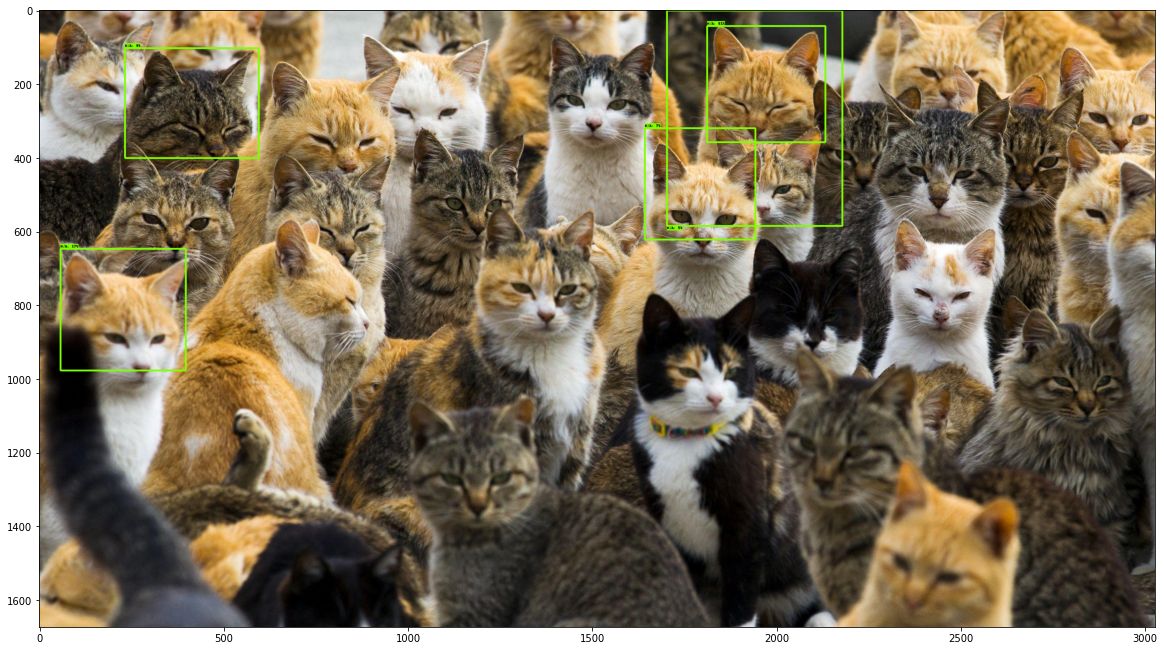

In [ ]:
path = '/content/aoshima-cats.jpg'
im = Image.open(path)

image_np = load_image_into_numpy_array(path)

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)
detection_scores = detections['detection_scores'][0]
detection_boxes = detections['detection_boxes'][0]
category_index = {0: {'id': 0, 'name': 'cat'}}

viz_utils.visualize_boxes_and_labels_on_image_array(
  image_np,
  detections['detection_boxes'][0].numpy(),
  (detections['detection_classes'][0].numpy() + 0).astype(int),
  detections['detection_scores'][0].numpy(),
  category_index,
  use_normalized_coordinates=True,
  max_boxes_to_draw=200,
  min_score_thresh=.05,
  agnostic_mode=False,
  line_thickness=5
)

plt.figure(figsize=(20,20))
plt.imshow(image_np)

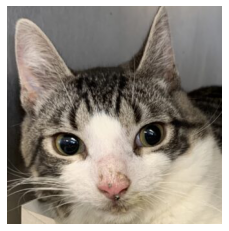

In [ ]:
from tensorflow.keras.preprocessing import image as tfimage
from PIL import Image 
from six import BytesIO
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

data_path = '/content/cat_data'
folders = os.listdir(data_path)
i=0

file_list = os.listdir(data_path)
for file in file_list:
  if file[-3:]=='jpg':
    # path = os.path.join(data_path, file)
    path = '/content/PSPCA_lititz_rescue_03_061720-768x552.jpg'
    im = Image.open(path)

    image_np = load_image_into_numpy_array(path)
    
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)
    detection_scores = detections['detection_scores'][0]
    detection_boxes = detections['detection_boxes'][0]

    width, height = im.size 

    for box, score in zip(detection_boxes, detection_scores):
      left = width*box[1].numpy()
      top = height*box[0].numpy()
      right = width*box[3].numpy()
      bottom = height*box[2].numpy()
      if score < .5:
        break
      
      # Cropped image of above dimension 
      # (It will not change orginal image) 
      im1 = im.crop((left, top, right, bottom)) 
      plt.imshow(im1)
      plt.axis('off')
      # Shows the image in image viewer 
      filename = file[:-4]
      # plt.savefig('/content/Classifier_Model/dataset/' + " ".join(re.findall("[a-zA-Z]+", filename)) + '/' + filename + '.jpg', )
      plt.show()
      i+=1
    break
  break

In [ ]:
!cp -r /content/Classifier_Model /content/drive/MyDrive/Telkomsel/mobile_app_logo

cp: cannot stat '/content/Classifier_Model': No such file or directory


## Dataset split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!cp -r /content/drive/MyDrive/Telkomsel/mobile_app_logo/Classifier_Model  /content/
import os

In [4]:
import random
import shutil
raw_data_dir = '/content/Classifier_Model/dataset'
split = 0.2

test_dir = '/content/Classifier_Model/test/'
train_dir = '/content/Classifier_Model/train/'

os.mkdir(test_dir)
os.mkdir(train_dir)

for label in os.listdir(raw_data_dir):
  label_dir = os.path.join(raw_data_dir, label)
  if os.path.isdir(label_dir):
    file_list = os.listdir(label_dir)
    random.shuffle(file_list)
    if len(file_list) >= 10:
      test_label_dir = os.path.join(test_dir, label)
      train_label_dir = os.path.join(train_dir, label)
      os.mkdir(test_label_dir)
      os.mkdir(train_label_dir)
      file_list_test = file_list[ int((1-split)*len(file_list)): ]
      file_list_train = file_list[ :int((1-split)*len(file_list)) ]
      for file in file_list_test:
        shutil.copyfile(os.path.join(label_dir, file), os.path.join(test_label_dir, file))
      for file in file_list_train:
        shutil.copyfile(os.path.join(label_dir, file), os.path.join(train_label_dir, file))

## Classifier Model

In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

testing_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size = 16
)

test_generator = testing_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size = 16
)

Found 117 images belonging to 6 classes.
Found 462 images belonging to 6 classes.


In [6]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [7]:
base_model.trainable = False

In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [9]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_generator, validation_data=test_generator,
    epochs = 10
)

Epoch 1/10
8/8 [==============================] - 74s 10s/step - loss: 1.9042 - accuracy: 0.4205 - val_loss: 0.7762 - val_accuracy: 0.7511
Epoch 2/10
8/8 [==============================] - 69s 10s/step - loss: 0.7787 - accuracy: 0.6715 - val_loss: 0.6664 - val_accuracy: 0.7706
Epoch 3/10
8/8 [==============================] - 68s 9s/step - loss: 0.7298 - accuracy: 0.7686 - val_loss: 0.5299 - val_accuracy: 0.8290
Epoch 4/10
8/8 [==============================] - 68s 9s/step - loss: 0.5799 - accuracy: 0.7966 - val_loss: 0.5079 - val_accuracy: 0.8225
Epoch 5/10
8/8 [==============================] - 68s 10s/step - loss: 0.6291 - accuracy: 0.7632 - val_loss: 0.4879 - val_accuracy: 0.8052
Epoch 6/10
8/8 [==============================] - 69s 9s/step - loss: 0.3940 - accuracy: 0.8629 - val_loss: 0.4781 - val_accuracy: 0.7987
Epoch 7/10
3/8 [==========>...................] - ETA: 10s - loss: 0.2581 - accuracy: 0.9340

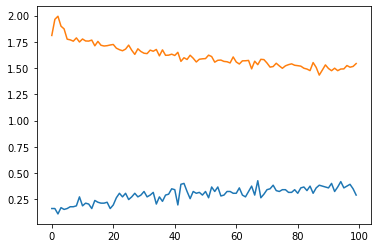

In [ ]:
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])

plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['loss'])